In [1]:
using StemCellModels
using DataFrames
using RCall
using ProgressMeter
using StatsBase
using Statistics
using Random
using StatsBase
R"""
library(ggplot2)
library(cowplot)
library(tidyverse)
library(viridis)
""";

┌ Info: Recompiling stale cache file /Users/marcwilliams/.julia/compiled/v1.0/StemCellModels/rUru5.ji for StemCellModels [bd92d27a-bb62-11e8-1f1b-ed4b990cdfb0]
└ @ Base loading.jl:1184
┌ Warning: Package StemCellModels does not have DataFrames in its dependencies:
│ - If you have StemCellModels checked out for development and have
│   added DataFrames as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with StemCellModels
└ Loading DataFrames into StemCellModels from project dependency, future warnings for StemCellModels are suppressed.
┌ Warning: RCall.jl: 
│ Attaching package: ‘cowplot’
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     ggsave
│ 
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/ffM0W/src/io.jl:113
┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
│ ✔ tibble  1.4.2     ✔ purrr   0.2.5
│ ✔ tidyr   0.8.

In this notebook I'll use a stochastic simulation of stem cell dynamics in homeostasis to to generate some synthetic cohorts of sequencing data to confirm that we can fit the model and recover the input paramters.

In [10]:
# This script contains some functions to do a Maximum Likelihood fit of our model
include("julia/optim.jl")

LLoptimizationresults (generic function with 1 method)

In [11]:
#function to calculate interval dN/dS from simulations
function intervaldnds_data(Msel, Mneut, mmin, Nmax; mgap = 5.0, mup = 1.0, mud = 1.0)
    #calculate cumulative dn/ds across cohort, normalizing for mutation rates
    dndscumsum = Float64[]
    dnvec = Float64[]
    dsvec = Float64[]
    driverVAFt = filter(x -> x >= mmin, Msel)
    passengerVAFt = filter(x -> x >= mmin, Mneut)
    freqs = collect(mmin:mgap:Nmax)
    for f in freqs
        dn = length(filter(x -> x< f, driverVAFt))/mud
        ds = length(filter(x -> x< f, passengerVAFt))/mup
        push!(dndscumsum, dn/ds)
        push!(dnvec, dn)
        push!(dsvec, ds)
    end
    return dndscumsum[2:end], freqs[2:end], dnvec[2:end], dsvec[2:end]
end

#function to simulate population of cells with different paramters
function simulatepopulation(;Δ = 0.0, ρ = 100.0, Amin = 1 ./ ρ, gap = 0.02, tend = 20.0, 
        Ncells = 1000, r = 0.5, λ = 1.0,
        sample = false, nsample = 10, Amax = 0.0)

    rangeN = 1:10^4
    Nits = 100
    Cntd = zeros(length(rangeN), Nits)
    Cntp = zeros(length(rangeN), Nits)
    Msel = Int64[]
    Mneut = Int64[]
    SMtog = SkinStemCellModel(Ncells, Δmut = Δ, μp = 0.001, μd = 0.001, tend = tend, r = r, λ = λ)
    @showprogress for i in 1:Nits
        scst = runsimulation(SMtog, progress = false, finish = "time", onedriver = true, restart = true)
        append!(Msel, filter!(x -> x > 0, counts(sort(StemCellModels.cellsconvert(scst.stemcells)[2]), rangeN)))
        append!(Mneut, filter!(x -> x > 0, counts(sort(StemCellModels.cellsconvert(scst.stemcells)[1]), rangeN)))
    end
    
    Asel = Msel ./ ρ
    Aneut = Mneut ./ ρ
    Asel = filter(x -> x >= Amin, Asel)
    Aneut = filter(x -> x >= Amin, Aneut)
    
    if sample
        prevlength = length(Asel)
        Asel = Asel[StatsBase.sample(1:length(Asel), nsample, replace = false)]
        Aneut = Aneut[StatsBase.sample(1:length(Aneut), 
                Int64(round(nsample * (length(Aneut) / prevlength))), replace = false)]
    end
    
    if Amax == 0.0
        Amax = maximum(Asel)
    end
    gap = 0.02

    x1 = intervaldnds_data(Asel, Aneut, Amin, Amax; mgap = gap, mup = SMtog.μp, mud = SMtog.μd)

    DFinterval = DataFrame(dnds = x1[1], A = x1[2], dn = x1[3] * SMtog.μd / Nits,
    ds = x1[4] * SMtog.μd / Nits)
 
    return DFinterval, SMtog, [DFinterval[:dn][end] * Nits, DFinterval[:ds][end] * Nits]
end

simulatepopulation (generic function with 1 method)

I'll first generate some synthetic cohorts and check that we can recover the input parameters.

In [12]:
Random.seed!(12345)

#create empty dataframe to store data
myDF = DataFrame([Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64,
    Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64], 
[:dnds, :A, :dndsfit, :dndsfitlq, :dndsfituq, :deltafit, :lambdarfit, 
    :deltafitlq, :lambdarfitlq, :deltafituq, :lambdarfituq, :sedelta, :selambda, :rsq, :deltatrue, :lambdartrue], 0)

for Δ in [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
    println(Δ)
    for rlam in [0.25, 0.5]
        println(rlam)
        rlambda = rlam
        DF1, SM = simulatepopulation(;Δ = Δ, tend = 30.0, Amin = 0.05, ρ = 100.0, λ = rlambda, Amax = 25.0)
        x = LLoptimizationresults(DF1[:dnds], DF1[:A]; t = 30.0, Amin = 0.05, ρ = 100.0)
        x.DF[:deltatrue] = Δ
        x.DF[:lambdartrue] = rlambda * SM.r
        append!(myDF, x.DF)
    end
end

0.0
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.1
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.15
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.2
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.25
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Linesearch failed, using alpha = 0.009280701884961908 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/marcwilliams/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.3
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.4
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


0.5
0.25


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


0.5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [13]:
@rput myDF
R"""
write_csv(myDF, "FinalFigures/data_for_figures/stemcell_simulation_examplefits.csv")
""";

┌ Warning: RCall.jl: Warning: Ignoring unknown aesthetics: fill
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/ffM0W/src/io.jl:113


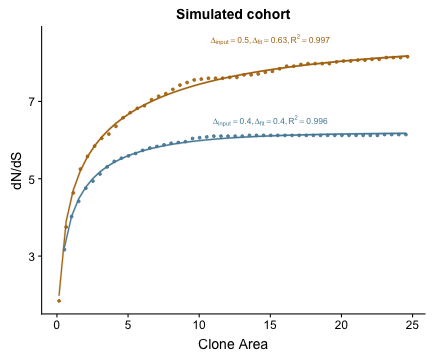

RObject{VecSxp}


In [14]:
R"""
library(jcolors)

textdf <-  myDF %>%
    filter(deltatrue > 0.3, lambdartrue == 0.25) %>%
    group_by(deltatrue) %>%
    mutate(deltag = paste0(deltatrue)) %>%
     mutate(label = paste("list(Delta[input] == ", deltatrue,", Delta[fit] == ", round(deltafit, 3), ",R^{2}==",round(rsq, 3) ,")")) %>%
    distinct(deltatrue, deltag, label) %>%
    mutate(y = ifelse(deltatrue == 0.4, 6.5, 8.6))

gsim <- myDF %>%
    filter(row_number() %% 5 == 0) %>%
    filter(deltatrue > 0.3, lambdartrue == 0.25) %>%
    filter(row_number() %% 5 == 0) %>%
    #filter(A < 15.0) %>%
    mutate(deltag = paste0(deltatrue)) %>%
    ggplot(aes(x = A)) +
    geom_point(aes(y = dnds,  group = deltag, fill = deltag, col = deltag), alpha = 0.9, size = 1) +
    geom_line(aes(y = dndsfit, group = deltag, fill = deltag, col = deltag), alpha = 0.3, size = 1) +
    geom_ribbon(aes(ymin = dndsfitlq, ymax = dndsfituq, group = deltag, fill = deltag, col = deltag), alpha = 0.1) +
    geom_text(data = textdf, aes(label = label, y = y, col = deltag), x = 15.0, size = 3, parse = TRUE) +
    xlab("Clone Area") +
    ylab("dN/dS") +
    ggtitle("Simulated cohort") +
    theme(legend.position = "none") +
    scale_color_jcolors(palette = "pal6")
gsim
"""

### Power to recover parameters

So as to guide our analysis when we turn to real data we'd like to know how many mutation we require to get accurate inferences. To do this I'll generate some synthetic cohorts with variable numbers of mutations.

In [15]:
#create some empty vectors and dataframes to store data
deltavec = Float64[]
rlambdavec = Float64[]
nmutsdn = Float64[]
nmutsds = Float64[]
itvec = Int64[]
sampvec = Float64[]
rsq = Float64[]
myDF = DataFrame([Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64], 
[:dnds, :A, :dndsfit, :deltafit, :lambdarfit, :rsq, :deltatrue, :lambdartrue, :its, :nsamples], 0)

myDF = DataFrame([Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64,
    Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64], 
[:dnds, :A, :dndsfit, :dndsfitlq, :dndsfituq, :deltafit, :lambdarfit, 
    :deltafitlq, :lambdarfitlq, :deltafituq, :lambdarfituq, :sedelta, :selambda, :rsq, :deltatrue, :lambdartrue,
    :its, :nsamples], 0)

#number od mutations to be samples
for nsamples in [5, 8, 10, 25, 50, 100, 250]
    #repeat 100 times
    for i in 1:100
        Random.seed!(i)
        Δ = 0.25
        r = 0.5
        lambda = 1.0
        rlambda = r * lambda
        DF1, SM, nmuts = simulatepopulation(;Δ = Δ, tend = 30.0, Amin = 0.05, ρ = 100.0, 
                            λ = lambda, r = r, sample = true, nsample = nsamples + 1)
        println(nmuts)
        if isnan(DF1[:dnds][1]) | (DF1[:dnds][1] == Inf)
            continue
        end
        x = LLoptimizationresults(DF1[:dnds], DF1[:A]; t = 30.0, Amin = 0.05, ρ = 100.0)
        x.DF[:deltatrue] = Δ
        x.DF[:lambdartrue] = rlambda
        x.DF[:its] = i
        x.DF[:nsamples] = nsamples
        append!(myDF, x.DF)
        push!(deltavec, x.Δ)
        push!(rlambdavec, x.rλ)
        push!(itvec, i)
        push!(nmutsdn, nmuts[1])
        push!(nmutsds, nmuts[2])
        push!(sampvec, nsamples)
        push!(rsq, x.DF[:rsq][1])
    end
end

DFfit = DataFrame(iterations = itvec,
nmutsdn = nmutsdn,
nmutsds = nmutsds,
delta = deltavec,
rlambda = rlambdavec,
nsamples = sampvec,
rsq = rsq)

DFfit[:product] = DFfit[:delta] .* DFfit[:rlambda];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[5.0, 1.0]


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02

[5.0, 1.0]



Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Warning: Cannot compute CI intervals, returning MLE for CIs
└ @ Main /Users/marcwilliams/Google Drive/dnds/for_paper/final_notebooks/julia/optim.jl:137
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Warning: Cannot compute CI intervals, returning MLE for CIs
└ @ Main /Users/marcwilliams/Google Drive/dnds/for_paper/final_notebooks/julia/optim.jl:137
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[5.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[8.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[8.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[10.0, 2.0]


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[10.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[10.0, 2.0]


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[10.0, 1.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[10.0, 2.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Warning: Cannot compute CI intervals, returning MLE for CIs
└ @ Main /Users/marcwilliams/Google Drive/dnds/for_paper/final_notebooks/julia/optim.jl:137
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[25.0, 5.0]


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[25.0, 5.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[25.0, 3.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 6.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[25.0, 4.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[50.0, 13.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[50.0, 12.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 7.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 13.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[50.0, 12.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 12.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 12.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02

[50.0, 9.0]



Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[50.0, 12.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[50.0, 11.0]


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[50.0, 10.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[50.0, 10.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[50.0, 11.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[50.0, 9.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[50.0, 7.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[50.0, 12.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[50.0, 8.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 25.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 23.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 22.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 14.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 22.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[100.0, 22.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 25.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 21.0]


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 19.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[100.0, 24.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 23.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 23.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 21.0]


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 19.0]


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 18.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 24.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 22.0]


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 15.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 23.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 23.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[100.0, 18.0]


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 15.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 21.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 18.0]


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 23.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 17.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 17.0]


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[100.0, 15.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 20.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[100.0, 19.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[100.0, 18.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 22.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 18.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[100.0, 14.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[100.0, 24.0]


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[100.0, 16.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 62.0]


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[250.0, 57.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 48.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 49.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 55.0]


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[250.0, 51.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 35.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 54.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 52.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 41.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 45.0]


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[250.0, 54.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[250.0, 62.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 52.0]


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 48.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 53.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[250.0, 43.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[250.0, 48.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

[250.0, 51.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 48.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[250.0, 43.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[250.0, 50.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 53.0]


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 49.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 59.0]


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 58.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 57.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 45.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 42.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 41.0]


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 52.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[249.0, 46.0]


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 48.0]


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 46.0]


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 49.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[250.0, 42.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 47.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 50.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[250.0, 51.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 60.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 45.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[250.0, 43.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

[250.0, 42.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 55.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 48.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 47.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:00

[250.0, 38.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 43.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 56.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 43.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 56.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 39.0]


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 51.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 38.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 51.0]


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 56.0]


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 43.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 48.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 42.0]


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 42.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 47.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 40.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 47.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 40.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 46.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 41.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[250.0, 42.0]


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 48.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 41.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 40.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 50.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 45.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 50.0]


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 37.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 50.0]


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 49.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 49.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:00

[250.0, 49.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:00

[250.0, 44.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 47.0]


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:00

[250.0, 54.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:00

[250.0, 46.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 34.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 59.0]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[250.0, 40.0]


In [17]:
#write data to file to for plotting later on
@rput DFfit
R"""
write_csv(DFfit, "FinalFigures/data_for_figures/stemcell_simulation_power.csv")
""";

┌ Warning: RCall.jl: Loading required package: lattice
│ Loading required package: survival
│ Loading required package: Formula
│ 
│ Attaching package: ‘Hmisc’
│ 
│ The following objects are masked from ‘package:dplyr’:
│ 
│     src, summarize
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     format.pval, units
│ 
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/ffM0W/src/io.jl:113
┌ Warning: RCall.jl: Warning: Removed 10 rows containing non-finite values (stat_sina).
│ Warning: Removed 10 rows containing non-finite values (stat_boxplot).
│ Warning: Removed 10 rows containing non-finite values (stat_sina).
│ Warning: Removed 10 rows containing non-finite values (stat_boxplot).
└ @ RCall /Users/marcwilliams/.julia/packages/RCall/ffM0W/src/io.jl:113


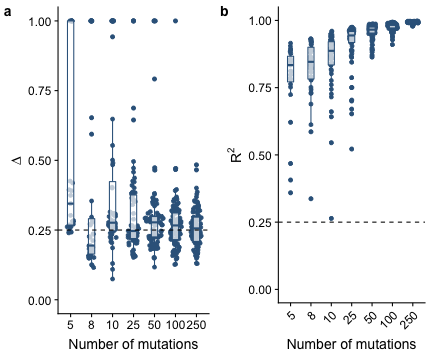

RObject{VecSxp}


In [18]:
@rput DFfit
R"""
library(Hmisc)
library(ggforce)

g1 <- DFfit %>%
    mutate(nsamples = factor(paste0(nsamples), 
    levels = Cs(5, 8, 10, 25, 50, 100, 250))) %>%
    ggplot(aes(x = nsamples, y = delta)) +
    #geom_violin(fill = "steelblue4") +
    geom_sina(col = "steelblue4") +
    geom_boxplot(width = 0.3, alpha = 0.7, col = "steelblue4") +
    ylim(c(0, 1.0)) +
    geom_hline(yintercept = 0.25, lty = 2) +
    xlab("Number of mutations") +
    ylab(expression(Delta))

g2 <- DFfit %>%
    mutate(nsamples = factor(paste0(nsamples), 
    levels = Cs(5, 8, 10, 25, 50, 100, 250))) %>%
    ggplot(aes(x = nsamples, y = rsq)) +
    geom_sina(col = "steelblue4") +
    geom_boxplot(width = 0.3, alpha = 0.7, col = "steelblue4") +
    ylim(c(0, 1.0)) +
    geom_hline(yintercept = 0.25, lty = 2) +
    xlab("Number of mutations") +
    ylab(expression(R^2)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

gout <- plot_grid(g1, g2, labels = c("a", "b"))
#save_plot("plots/2.Stem-Cell-Theory/power-accurate-inference.pdf", gout, base_height = 5, base_width = 9)
gout
"""

In [19]:
R"""
sessionInfo()
"""

RObject{VecSxp}
R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.6

Matrix products: default
BLAS: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_GB.UTF-8/en_GB.UTF-8/en_GB.UTF-8/C/en_GB.UTF-8/en_GB.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggforce_0.1.3     Hmisc_4.1-1       Formula_1.2-3     survival_2.42-3  
 [5] lattice_0.20-35   bindrcpp_0.2.2    jcolors_0.0.4     viridis_0.5.1    
 [9] viridisLite_0.3.0 forcats_0.3.0     stringr_1.3.1     dplyr_0.7.7      
[13] purrr_0.2.5       readr_1.1.1       tidyr_0.8.2       tibble_1.4.2     
[17] tidyverse_1.2.1   cowplot_0.9.3     ggplot2_3.1.0    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0          lubridate_